Number of observations:
tau = 27:  29138
Closest tau below 27:  907253
Closest tau above 27:  886810


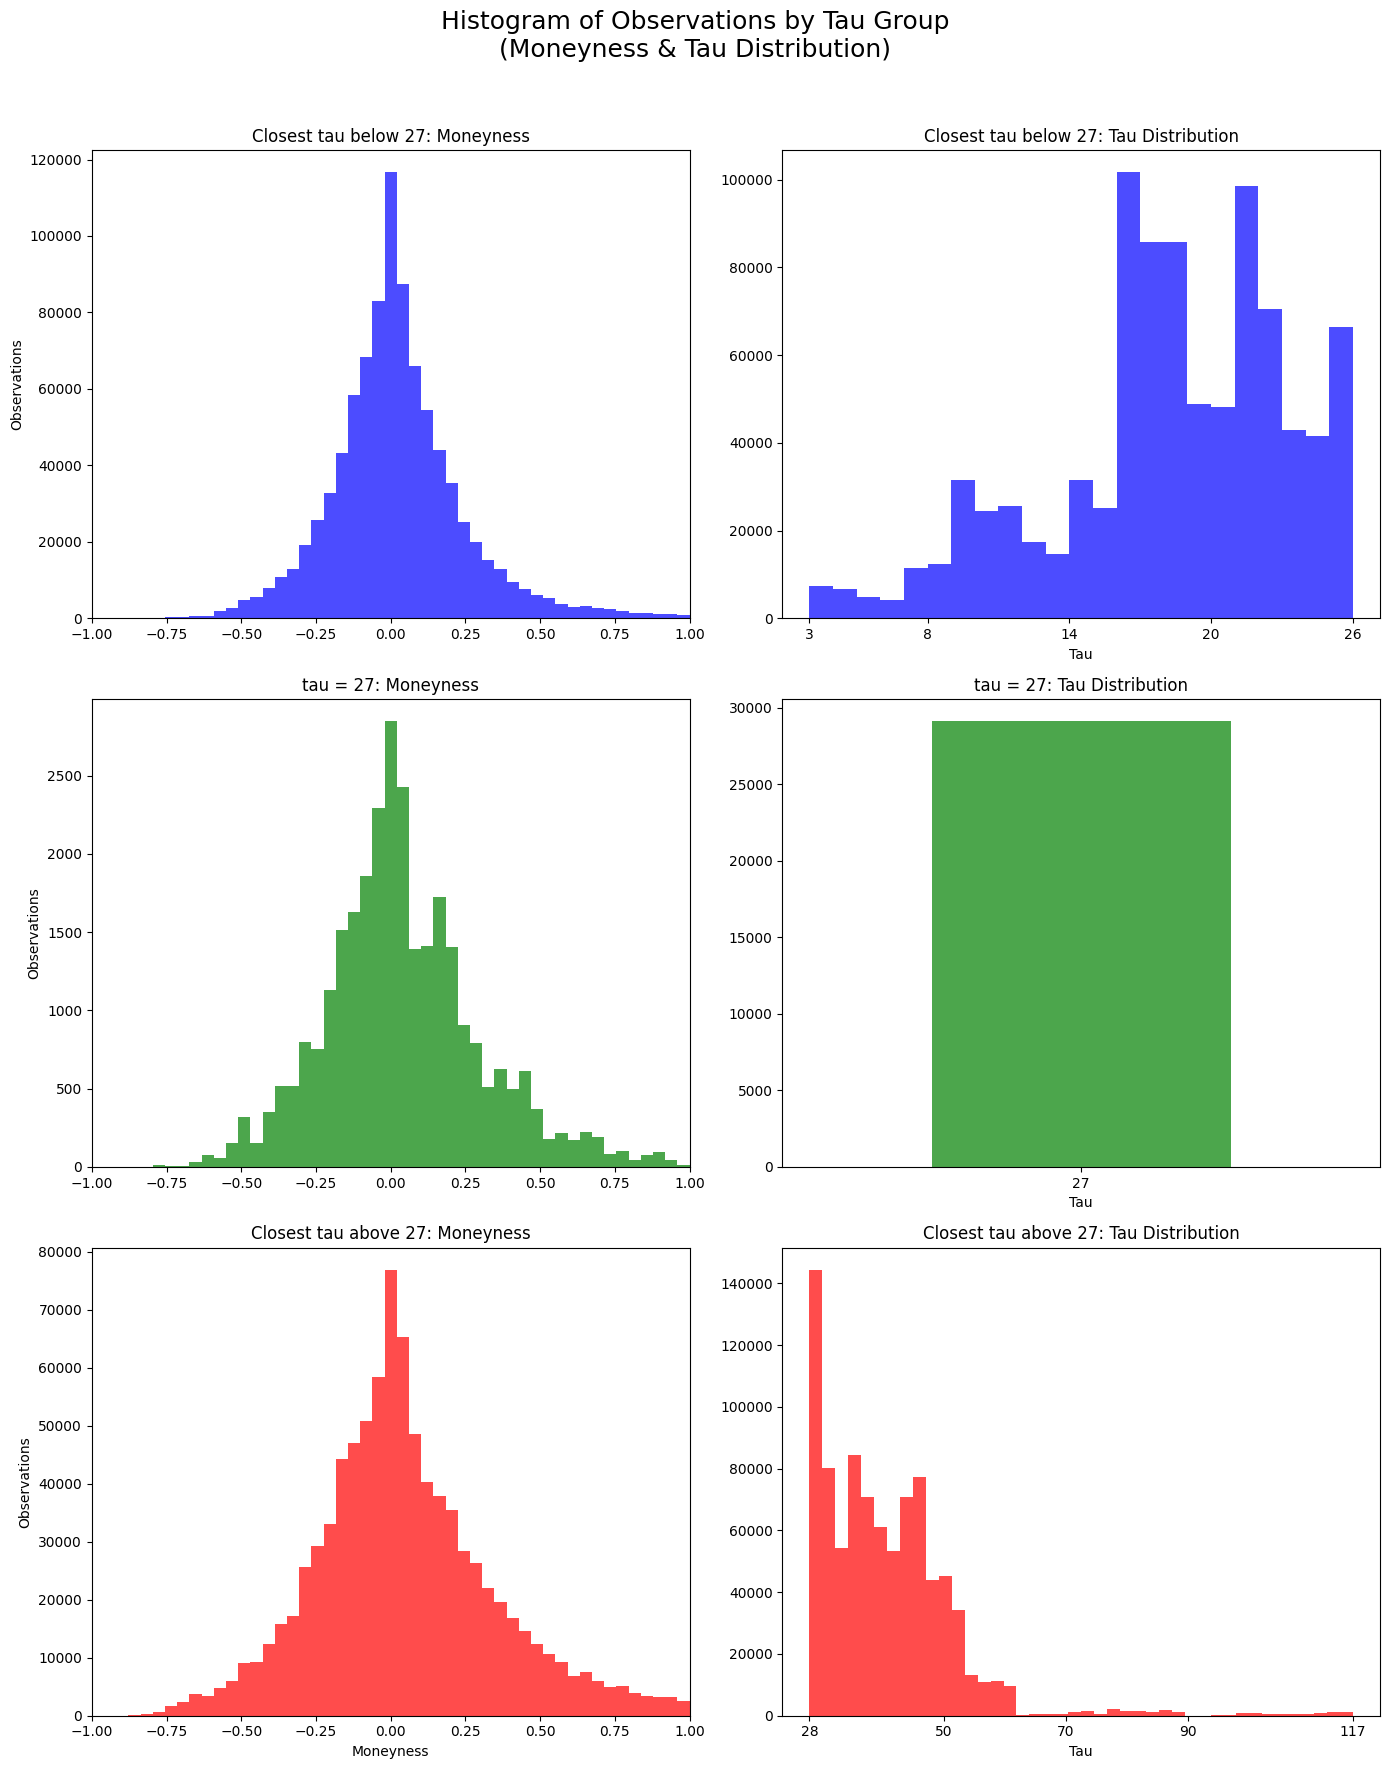

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory
path = "/Users/irtg/Documents/Github/BTC-premia/SVI_independent_tau/"
os.chdir(path)

# Folder to save the plots
plot_folder = os.path.join(path, "Summary_Statistics", "Tau-independent", "unique", 
                           "moneyness_step_0d01")
os.makedirs(plot_folder, exist_ok=True)

# Load the dataset
data_path = os.path.join(path, "Data", "processed", "20172022_processed_1_3_4.csv")
df = pd.read_csv(data_path)

# Convert 'date' to datetime for grouping
df['date'] = pd.to_datetime(df['date'])

# Data cleaning: keep rows with IV > 0, tau >= 3, and quantity > 0
df = df[(df['IV'] > 0) & (df['tau'] >= 3)]
df = df[df['quantity'] > 0]

# Calculate moneyness: moneyness = K / BTC_price - 1
df['moneyness'] = df['K'] / df['BTC_price'] - 1

# Limit the data to moneyness between -1 and 1
df = df[(df['moneyness'] >= -1) & (df['moneyness'] <= 1)]

# Initialize lists to collect groups
rows_tau27 = []      # Observations where tau == 27 (if available)
rows_tau_below = []  # Observations corresponding to the maximum tau below 27 (if no tau==27)
rows_tau_above = []  # Observations corresponding to the minimum tau above 27 (if no tau==27)

# Tolerance for comparing floating point tau values
tol = 1e-6

# Process each date individually
for date, group in df.groupby('date'):
    # Check if any observation has tau == 27 (within tolerance)
    group_27 = group[np.isclose(group['tau'], 27, atol=tol)]
    if not group_27.empty:
        rows_tau27.append(group_27)
    else:
        # No tau exactly 27 for this date.
        taus = group['tau'].unique()
        taus_below = taus[taus < 27]
        taus_above = taus[taus > 27]
        if len(taus_below) > 0:
            max_tau_below = np.max(taus_below)
            group_below = group[np.isclose(group['tau'], max_tau_below, atol=tol)]
            rows_tau_below.append(group_below)
        if len(taus_above) > 0:
            min_tau_above = np.min(taus_above)
            group_above = group[np.isclose(group['tau'], min_tau_above, atol=tol)]
            rows_tau_above.append(group_above)

# Combine the groups into DataFrames (if a group is empty, create an empty DataFrame)
df_tau27 = pd.concat(rows_tau27) if rows_tau27 else pd.DataFrame()
df_tau_below = pd.concat(rows_tau_below) if rows_tau_below else pd.DataFrame()
df_tau_above = pd.concat(rows_tau_above) if rows_tau_above else pd.DataFrame()

# Print the number of observations in each group
print("Number of observations:")
print("tau = 27: ", len(df_tau27))
print("Closest tau below 27: ", len(df_tau_below))
print("Closest tau above 27: ", len(df_tau_above))

# Define histogram bins for moneyness, fixed to [-1, 1]
moneyness_bins = np.linspace(-1, 1, 50)

# Create a 3-by-2 subplot: 3 rows for the three groups;
# left column for moneyness histogram, right column for tau histogram.
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# --- Row 0: Closest tau below 27 ---
axes[0, 0].hist(df_tau_below['moneyness'], bins=moneyness_bins, color='blue', alpha=0.7)
axes[0, 0].set_title('Closest tau below 27: Moneyness')
axes[0, 0].set_ylabel('Observations')
axes[0, 0].set_xlim(-1, 1)

if not df_tau_below.empty:
    tau_min_below = df_tau_below['tau'].min()
    tau_max_below = df_tau_below['tau'].max()
    tau_bins_below = np.linspace(tau_min_below, tau_max_below, len(df_tau_below["tau"].unique()))
    axes[0, 1].hist(df_tau_below['tau'], bins=tau_bins_below, color='blue', alpha=0.7)
    axes[0, 1].set_title('Closest tau below 27: Tau Distribution')
    axes[0, 1].set_xlabel('Tau')
    # Set xticks to show five evenly spaced groups (labels)
    xticks_below = [tau_min_below, 8, 14, 20, tau_max_below]
    axes[0, 1].set_xticks(xticks_below)
else:
    axes[0, 1].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')

# --- Row 1: tau = 27 ---
axes[1, 0].hist(df_tau27['moneyness'], bins=moneyness_bins, color='green', alpha=0.7)
axes[1, 0].set_title('tau = 27: Moneyness')
axes[1, 0].set_ylabel('Observations')
axes[1, 0].set_xlim(-1, 1)

if not df_tau27.empty:
    # For tau = 27, use one bin that covers values around 27, and force the x-axis to show only 27.
    axes[1, 1].hist(df_tau27['tau'], bins=[26.5, 27.5], color='green', alpha=0.7)
    axes[1, 1].set_title('tau = 27: Tau Distribution')
    axes[1, 1].set_xlabel('Tau')
    axes[1, 1].set_xlim(26, 28)
    axes[1, 1].set_xticks([27])
else:
    axes[1, 1].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')

# --- Row 2: Closest tau above 27 ---
axes[2, 0].hist(df_tau_above['moneyness'], bins=moneyness_bins, color='red', alpha=0.7)
axes[2, 0].set_title('Closest tau above 27: Moneyness')
axes[2, 0].set_ylabel('Observations')
axes[2, 0].set_xlabel('Moneyness')
axes[2, 0].set_xlim(-1, 1)

if not df_tau_above.empty:
    tau_min_above = df_tau_above['tau'].min()
    tau_max_above = df_tau_above['tau'].max()
    tau_bins_above = np.linspace(tau_min_above, tau_max_above, len(df_tau_above["tau"].unique()) // 2)
    axes[2, 1].hist(df_tau_above['tau'], bins=tau_bins_above, color='red', alpha=0.7)
    axes[2, 1].set_title('Closest tau above 27: Tau Distribution')
    axes[2, 1].set_xlabel('Tau')
    # Set xticks to show five evenly spaced groups (labels)
    xticks_above = [tau_min_above, 50, 70, 90, tau_max_above]
    axes[2, 1].set_xticks(xticks_above)
else:
    axes[2, 1].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')

plt.suptitle("Histogram of Observations by Tau Group\n(Moneyness & Tau Distribution)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(plot_folder, "moneyness_tau_distribution.png"))
plt.show()